# Surfa Exploratory Data Analysis

With this project we try to predict the tip a Takeaway driver receives during a given shift in future.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

sns.set_theme(context='notebook', style='darkgrid')

`tips.csv` contains data about the **tips** drivers have recived ina given day, and the number of **orders** and **distance** traveled for that day.

The file was created based on teh information provided to three takeaway drives through their work app.

In [2]:
df = pd.read_csv('../data/tips.csv', parse_dates=['Date'], index_col='Date')
df.head(7)

,Tip,Orders,Distance,DriverID
Date,,,,
2021-01-10,0.00,8,28.0,1
2021-01-02,0.00,5,13.9,1
2021-01-13,0.00,8,20.0,1
2021-01-16,0.00,10,30.0,1
2021-01-21,2.45,11,37.5,1
2021-01-23,0.00,15,31.2,1
2021-01-25,0.00,4,9.7,1


Let's see if we can find any obvious patterns when we plot our observations over time.

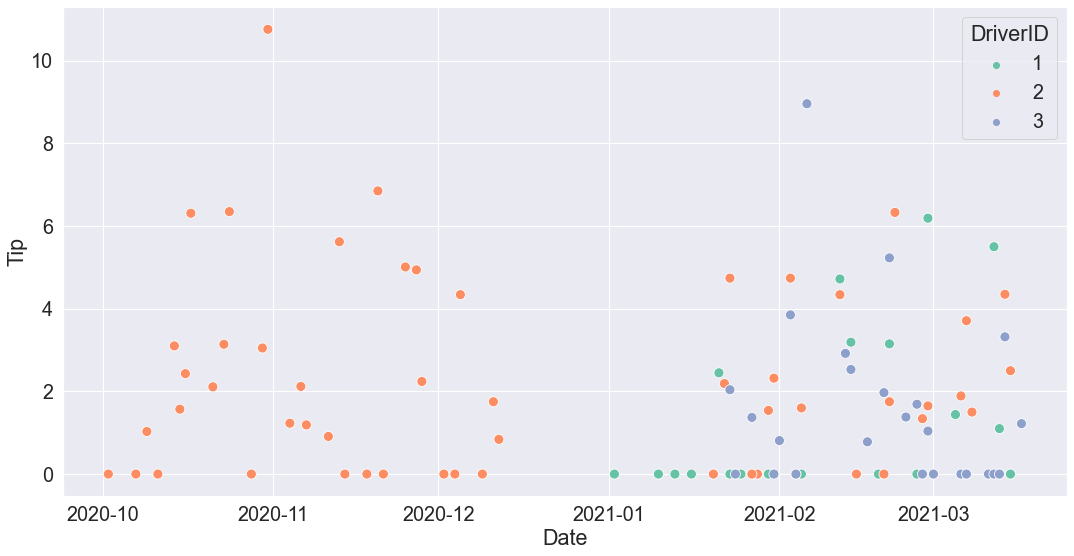

In [4]:
plt.figure(figsize=(18,9))
sns.set(font_scale=1.8)
ax = sns.scatterplot(x='Date', y='Tip', hue='DriverID', palette='Set2', s=100, data=df)

plt.show()

Nothing so far, other than the fact there are a lot of shifts with 0 tips which may confuse the algorithm.

# Enriching data

## Derived features 

Let's start by adding the `Tip` per `Order`. 

We are interested in the `TipPerOrder` because some drivers may double longer shifts and get double `Orders` and double `Tip` but we don't want the model to think those days were doubly profitable.

That is why our Label for prediction is `TipPerOrder` instead of `Tip`.

In [ ]:
df['TipPerOrder'] = df['Tip'] / df['Orders']
df.loc[~np.isfinite(df['TipPerOrder']), 'TipPerOrder'] = np.nan
df.sort_values('TipPerOrder', ascending=False).head(7)

,Tip,Orders,Distance,DriverID,TipPerOrder
Date,,,,,
2020-10-31,10.76,13,32.3,2,0.827692
2021-02-22,6.33,9,23.3,2,0.703333
2021-02-06,8.96,13,30.2,3,0.689231
2020-11-20,6.85,10,26.2,2,0.685000
2020-10-17,6.31,11,35.7,2,0.573636
2021-02-28,6.19,11,32.5,1,0.562727
2020-11-27,4.94,9,35.5,2,0.548889


It is also possible that there are differences between days of the week (e.g. generous parties on Fridays and grumpy customers on Mondays) so it could be useful to have a feature for that.

In [ ]:
df['DayOfWeek'] = df.index.dayofweek
df.head() # 0 is Monday, 1 is Tuesday and so on

,Tip,Orders,Distance,DriverID,TipPerOrder,DayOfWeek
Date,,,,,,
2021-01-10,0.00,8,28.0,1,0.000000,6
2021-01-02,0.00,5,13.9,1,0.000000,5
2021-01-13,0.00,8,20.0,1,0.000000,2
2021-01-16,0.00,10,30.0,1,0.000000,5
2021-01-21,2.45,11,37.5,1,0.222727,3


Let's see how different days of the week compare to each other. 

We are looking for an overview, anomalies and patterns.

In [ ]:
dow_df=df.groupby('DayOfWeek') \
    .agg(
        {'Tip':'sum', 
        'Orders':'sum', 
        'Distance':'sum', 
        'DriverID': 'count',
        }) \
    .rename(columns={'DriverID':'Observations'})
dow_df['TipPerOrder'] = dow_df['Tip'] / dow_df['Orders']

dow_df

,Tip,Orders,Distance,Observations,TipPerOrder
DayOfWeek,,,,,
0,11.14,79,204.5,9,0.141013
2,25.70,185,557.4,19,0.138919
3,4.02,54,178.7,6,0.074444
4,52.41,204,583.7,22,0.256912
5,58.53,308,847.6,27,0.190032
6,38.43,163,507.0,18,0.235767


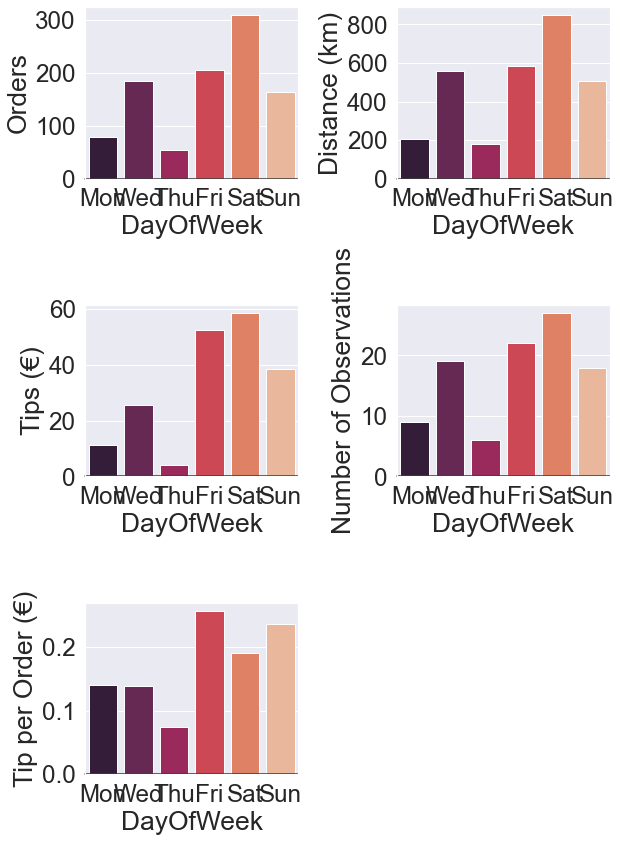

In [ ]:

fig, ((ax1, ax2), (ax3, ax4), (ax_tip_order, ax6)) = plt.subplots(3, 2, figsize=(9, 12), sharex=False)
sns.set(font_scale=1.4)

x = dow_df.index.map({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})
sns.barplot(x=x, y=dow_df['Orders'], palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Orders")

sns.barplot(x=x, y=dow_df['Distance'], palette="rocket", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Distance (km)")

sns.barplot(x=x, y=dow_df['Tip'], palette="rocket", ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("Tips (€)")

sns.barplot(x=x, y=dow_df['TipPerOrder'], palette="rocket", ax=ax_tip_order)
ax_tip_order.axhline(0, color="k", clip_on=False)
ax_tip_order.set_ylabel("Tip per Order (€)")

sns.barplot(x=x, y=dow_df['Observations'], palette="rocket", ax=ax4)
ax4.axhline(0, color="k", clip_on=False)
ax4.set_ylabel("Number of Observations")

ax6.axis('off')

fig.tight_layout()

plt.show()


The first four graphs, `Orders`, `Distande`, `Tip` and `Number of Observations` all follow a very similar pattern. That is because they all depend on the number of observations.

`TipPerOrer` breaks that pattern because after we have enough observations for each day of the week, the number of observations should not influence `TipPerOrder` anymore. However, if we have few observations for any day of the week, all features are susceptable to flukes.

We also notice the **weekends seem to be more profitable**, however that may be because weekdays have less observations because the workload is lower on weekdays.

Also in over 100 observations we don't have a single shift that took place on a Tuesday.

Let's see how days of the week are different in regards to `TipPerOrder`. We will use a jittered scatterplot for a detailed view and a boxplot for an overview that also handles outliers.

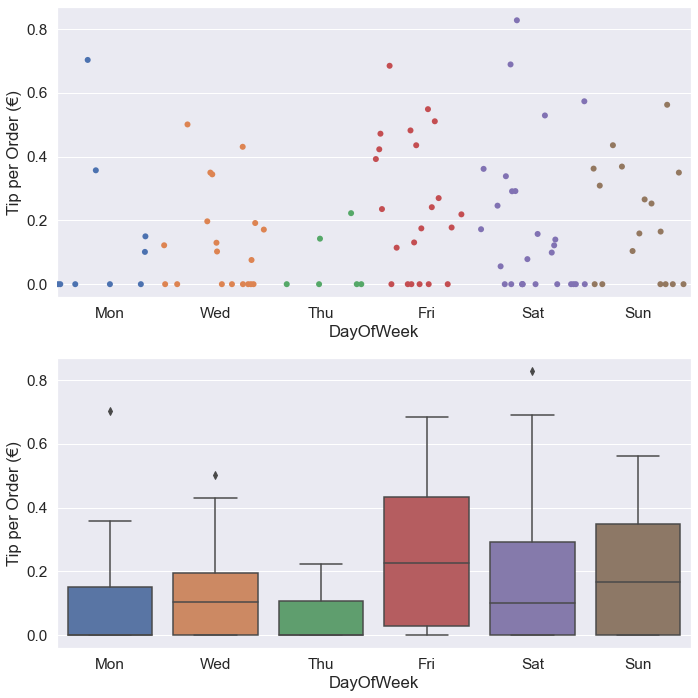

In [ ]:
tdf = df.sort_values('DayOfWeek')

fig, (ax_scatter, ax_box) = plt.subplots(2, 1, figsize=(10, 10), sharex=False)

x = tdf['DayOfWeek'].map({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})

sns.stripplot(x=x, y = tdf['TipPerOrder'], jitter=0.5, size=6, ax=ax_scatter)
ax_scatter.set_ylabel("Tip per Order (€)")

sns.boxplot(x=x, y=tdf['TipPerOrder'], ax=ax_box)
ax_box.set_ylabel("Tip per Order (€)")


fig.tight_layout()

plt.show()

This graph doesn't necessairly show a very strong correlation.
But weekends still seem to have higher tips per order, although that may be a fluke because we don't have enough data for weekdays.

Friday seems especially profitable though, with 50% chance of getting a tip up to 4 Euro per 10 orders.

Since there seems to be a big difference between weekdays and weekends in paarticular, we can introduce a variable for that distinction.
It may be possible that the generalization will improve the model.

In [ ]:
df['IsWeekend'] = (df['DayOfWeek'] > 3).astype(float)  # 4, 5, 6 are Fri, Sat, Sun respectievely

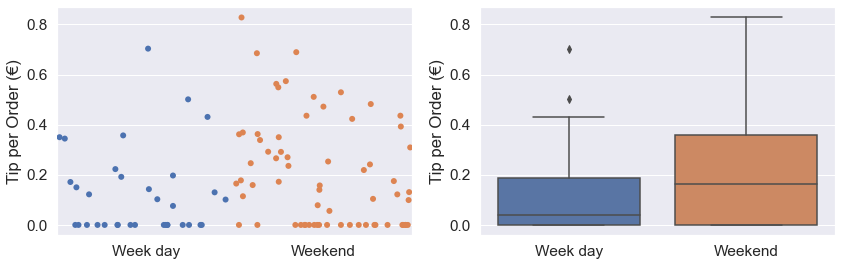

In [ ]:
tdf = df.sort_values('DayOfWeek')
tdf['IsWeekend'] = tdf['IsWeekend'].map({0:'Week day', 1:'Weekend'}) 

fig, (ax_scatter, ax_box) = plt.subplots(1, 2, figsize=(12, 4), sharex=False)

sns.stripplot(x=tdf['IsWeekend'], y = tdf['TipPerOrder'], jitter=0.5, size=6, ax=ax_scatter)
ax_scatter.set_ylabel("Tip per Order (€)")
ax_scatter.set_xlabel('')

sns.boxplot(x=tdf['IsWeekend'], y=tdf['TipPerOrder'], ax=ax_box)
ax_box.set_ylabel("Tip per Order (€)")
ax_box.set_xlabel('')

fig.tight_layout()

plt.show()

We see the same pattern even more clearly.

`DayOfWeek` and `IsWeekend` will definetely guide the model in the right direction.

Now let's confirm this insight statistically.

Correlation for DayOfWeek is 0.12
Correlation for IsWeekend is 0.19


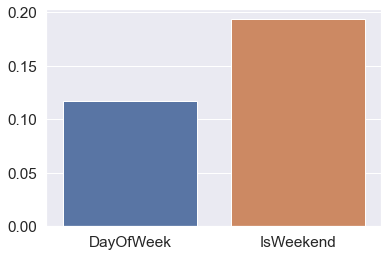

In [ ]:
cols = ['DayOfWeek', 'IsWeekend', 'TipPerOrder']
cm = np.corrcoef(df[cols].dropna().values, rowvar=0)

sns.barplot(x=cols[0:-1], y = cm[-1][0:-1])

print(f'Correlation for DayOfWeek is {cm[-1][0]:.2f}')
print(f'Correlation for IsWeekend is {cm[-1][1]:.2f}')

This is a **quite bad** score because, as we found out on [further investigation](https://statistics.laerd.com/statistical-guides/pearson-correlation-coefficient-statistical-guide.php), 
the *Pearson Product-Moment Correlation* **does not** apply when one of the features is categorical. 

Let us instead use a proper statistical test such as [the one-way ANOVA F-test](https://en.wikipedia.org/wiki/F-test#Multiple-comparison_ANOVA_problems)

To make sure that we can apply this test we tested the following preconditions:
*   Independence – Categories are mutually exclusive, data is not repeted, observations were colected independently of each other.
*   Normality – Data is sampled from a normal distribuition. While we do sample normal observations (since we use records about ALL the orders for a driver) we do not sample a normal selection of drivers. Our sampled drivers are mostly male, young, Fontys students and friends. However that is acceptabale because we do not try to infer any knowledge about drivers as a whole and we recognize that any insights gained are scoped to the selection of drivers for sampling (which can be easily extended later)
*   Homogenity of variences – The variance among different categories is similar, as demonstrated by a good score (0.53 and 0.10) on Leven's Test


In [ ]:
import scipy.stats as stats
import researchpy as rp

print(
    'The result of the Levene Test for a given day of the week is: ',
    stats.levene( 
        df['TipPerOrder'][df['DayOfWeek'] == 0].dropna(),
        df['TipPerOrder'][df['DayOfWeek'] == 2].dropna(),
        df['TipPerOrder'][df['DayOfWeek'] == 3].dropna(),
        df['TipPerOrder'][df['DayOfWeek'] == 4].dropna(),
        df['TipPerOrder'][df['DayOfWeek'] == 5].dropna(),
        df['TipPerOrder'][df['DayOfWeek'] == 6].dropna(),
    ).pvalue,
)

print(
    'The result of the Levene Test for week days vs weekends is: ',
    stats.levene( 
        df['TipPerOrder'][df['IsWeekend'] == 0].dropna(),
        df['TipPerOrder'][df['IsWeekend'] == 1].dropna(), 
    ).pvalue,
)


print(
    'The ONOVA pvalue for DayOfWeek is ',
    stats.f_oneway(
        df['TipPerOrder'][df['DayOfWeek'] == 0].dropna(),
        df['TipPerOrder'][df['DayOfWeek'] == 2].dropna(),
        df['TipPerOrder'][df['DayOfWeek'] == 3].dropna(),
        df['TipPerOrder'][df['DayOfWeek'] == 4].dropna(),
        df['TipPerOrder'][df['DayOfWeek'] == 5].dropna(),
        df['TipPerOrder'][df['DayOfWeek'] == 6].dropna(),
    ).pvalue
)

print(
    'The ONOVA pvalue for week days vs weekends is ',
    stats.f_oneway(
        df['TipPerOrder'][df['IsWeekend'] == 0].dropna(),
        df['TipPerOrder'][df['IsWeekend'] == 1].dropna(),
    ).pvalue
)

The result of the Levene Test for a given day of the week is:  0.5326202605182905
The result of the Levene Test for week days vs weekends is:  0.10262222764477963
The ONOVA pvalue for DayOfWeek is  0.3274520322161249
The ONOVA pvalue for week days vs weekends is  0.05392965668648481


A `pvalue` of `0.32` means that we **cannot prove** there is a statistically significant difference between the `TipPerOrder` on a given `DayOfWeek`. However, a `pvalue` of `0.05` **does proove** that there is a **statistically signficant** difference between week days and weekend days.

## Combining Data

A possible explanation for differences in tips may come from weather.

Our hypothesis is that people tend to tip more in worse weather: cold, wind, rain and snow.

We will use an extensive dataset from KNMI.

The features are as follows:

[OriginalName], [NewName] = [Description]

**YYYYMMDD, INDEX**  =  Date of the observation (YYYY=year MM=month DD=day)

DDVEC     =  Vector mean wind direction in degrees (360=north, 90=east, 180=south, 270=west, 0=calm/variable) (http://www.knmi.nl/kennis-en-datacentrum/achtergrond/klimatologische-brochures-en-boeken)

FHVEC     =  Vector mean windspeed (in 0.1 m/s) (http://www.knmi.nl/kennis-en-datacentrum/achtergrond/klimatologische-brochures-en-boeken)

**FG, MeanWind**        = Daily mean windspeed (in 0.1 m/s) 

**FHX, MaxWind**       = Maximum hourly mean windspeed (in 0.1 m/s)

**FHXH, MaxWindHour**      = Hourly division in which FHX was measured

**FHN, MinWind**       = Minimum hourly mean windspeed (in 0.1 m/s)

**FHNH, MinWindHour**      = Hourly division in which FHN was measured

**FXX, MaxWindGust**       = Maximum wind gust (in 0.1 m/s)

**FXXH, MaxWindGustHour**      = Hourly division in which FXX was measured

**TG, MeanTemp**        = Daily mean temperature in (0.1 degrees Celsius)

**TN, MinTemp**        = Minimum temperature (in 0.1 degrees Celsius)

**TNH, MinTempHour**       = Hourly division in which TN was measured

**TX, MaxTemp**        = Maximum temperature (in 0.1 degrees Celsius)

**TXH, MaxTempHour**       = Hourly division in which TX was measured

T10N, *Ignored*      = Minimum temperature at 10 cm above surface (in 0.1 degrees Celsius)

T10NH, *Ignored*     = 6-hourly division in which T10N was measured; 6=0-6 UT, 12=6-12 UT, 18=12-18 UT, 24=18-24 UT 

**SQ, SunshineDur**        = Sunshine duration (in 0.1 hour) calculated from global radiation (-1 for <0.05 hour)

SP, *Ignored*        = Percentage of maximum potential sunshine duration

Q, *Ignored*        = Global radiation (in J/cm2)

**DR, RainDur**        = Precipitation duration (in 0.1 hour)

**RH, RainAmount**        = Daily precipitation amount (in 0.1 mm) (-1 for <0.05 mm)

**RHX, MaxRainAmount**       = Maximum hourly precipitation amount (in 0.1 mm) (-1 for <0.05 mm)

**RHXH, MaxRainAmountHour**      = Hourly division in which RHX was measured

**PG, MeanPress**        = Daily mean sea level pressure (in 0.1 hPa) calculated from 24 hourly values

**PX, MaxPress **        = Maximum hourly sea level pressure (in 0.1 hPa)

**PXH, MaxPressHour**       = Hourly division in which PX was measured

**PN, MinPress**        = Minimum hourly sea level pressure (in 0.1 hPa)

**PNH, MinPressHour**       = Hourly division in which PN was measured

**VVN, MinVis**       = Minimum visibility; 0: <100 m, 1:100-200 m, 2:200-300 m,..., 49:4900-5000 m, 50:5-6 km, 56:6-7 km, 57:7-8 km,..., 79:29-30 km, 80:30-35 km, 81:35-40 km,..., 89: >70 km)

**VVNH, MinVisHour**      = Hourly division in which VVN was measured

**VVX, MaxVis**       = Maximum visibility; 0: <100 m, 1:100-200 m, 2:200-300 m,..., 49:4900-5000 m, 50:5-6 km, 56:6-7 km, 57:7-8 km,..., 79:29-30 km, 80:30-35 km, 81:35-40 km,..., 89: >70 km)

**VVXH, MaxVisHour**      = Hourly division in which VVX was measured

**NG, Cloudness**        = Mean daily cloud cover (in octants, 9=sky invisible)

**UG, MeanHum**        = Daily mean relative atmospheric humidity (in percents)

**UX, MaxHum**        = Maximum relative atmospheric humidity (in percents)

**UXH, MaxHumHour**       = Hourly division in which UX was measured

**UN, MinHum**        = Minimum relative atmospheric humidity (in percents) 

**UNH, MinHumHour**       = Hourly division in which UN was measured

EV24, *Ignored*      = Potential evapotranspiration (Makkink) (in 0.1 mm)


In [ ]:
weather = pd.read_csv('../data/weather.csv', parse_dates=['YYYYMMDD'], index_col='YYYYMMDD', na_values='     ', header=44, dtype=float, converters = {'YYYYMMDD': str} ) \
            .loc['2020-01-01':] \
            .rename(columns=str.strip) \
            .rename(columns={
                'FG': 'MeanWind',
                'FHX': 'MaxWind',
                'FHXH': 'MaxWindHour',
                'FHN': 'MinWind',
                'FHNH': 'MinWindHour',
                'FXX': 'MaxWindGust',
                'FXXH': 'MaxWindGustHour',
                'TG': 'MeanTemp',
                'TN': 'MinTemp',
                'TNH': 'MinTempHour',
                'TX': 'MaxTemp',
                'TXH': 'MaxTempHour',
                'SQ': 'SunshineDur',
                'DR': 'RainDur',
                'RH': 'RainAmount',
                'RHX': 'MaxRainAmount',
                'RHXH': 'MaxRainAmountHour',
                'PG': 'MeanPress',
                'PX': 'MaxPress',
                'PXH': 'MaxPressHour',
                'PN': 'MinPress',
                'PNH': 'MinPressHour',
                'VVN': 'MinVis',
                'VVNH': 'MinVisHour',
                'VVX': 'MaxVis',
                'VVXH': 'MaxVisHour',
                'NG': 'Cloudness',
                'UG': 'MeanHum',
                'UX': 'MaxHum',
                'UXH': 'MaxHumHour',
                'UN': 'MinHum',
                'UNH': 'MinHumHour',
            }, errors='raise')
print(weather.shape)
weather.loc[:,].head(7)

<ipython-input-14-132300fbfc2b>:1: ParserWarning: Both a converter and dtype were specified for column YYYYMMDD - only the converter will be used
  weather = pd.read_csv('./data/weather.csv', parse_dates=['YYYYMMDD'], index_col='YYYYMMDD', na_values='     ', header=44, dtype=float, converters = {'YYYYMMDD': str} ) \


(442, 40)


,STN,DDVEC,FHVEC,MeanWind,MaxWind,MaxWindHour,MinWind,MinWindHour,MaxWindGust,MaxWindGustHour,...,MinVisHour,MaxVis,MaxVisHour,Cloudness,MeanHum,MaxHum,MaxHumHour,MinHum,MinHumHour,EV24
YYYYMMDD,,,,,,,,,,,,,,,,,,,,,
2020-01-01,370.0,159.0,16.0,21.0,40.0,24.0,10.0,17.0,70.0,24.0,...,10.0,37.0,1.0,8.0,97.0,98.0,6.0,92.0,1.0,1.0
2020-01-02,370.0,182.0,37.0,38.0,50.0,19.0,20.0,4.0,90.0,19.0,...,1.0,70.0,16.0,8.0,94.0,98.0,1.0,87.0,23.0,2.0
2020-01-03,370.0,232.0,40.0,53.0,70.0,9.0,30.0,19.0,120.0,14.0,...,17.0,70.0,1.0,7.0,91.0,96.0,14.0,84.0,8.0,1.0
2020-01-04,370.0,249.0,43.0,45.0,60.0,9.0,20.0,22.0,100.0,12.0,...,19.0,74.0,14.0,8.0,92.0,97.0,21.0,80.0,14.0,3.0
2020-01-05,370.0,213.0,32.0,32.0,40.0,11.0,30.0,1.0,60.0,13.0,...,4.0,75.0,13.0,8.0,87.0,95.0,1.0,77.0,13.0,1.0
2020-01-06,370.0,190.0,36.0,39.0,60.0,22.0,20.0,17.0,100.0,23.0,...,1.0,80.0,11.0,6.0,80.0,95.0,2.0,65.0,14.0,6.0
2020-01-07,370.0,211.0,49.0,51.0,70.0,21.0,40.0,2.0,120.0,21.0,...,10.0,74.0,21.0,8.0,88.0,96.0,3.0,79.0,17.0,2.0


This data set contains a lot of information that could be useful in preddicting tips (e.g. temperature, precipitations, wind), however we can only use columns for which we can get preddictions from somewhere else.

Now we will join these datasets so that we have access to the meteorological data when we train the model.

In [ ]:
wdf = df.join(weather) # Join on the Indexes by default
wdf.head(7)

,Tip,Orders,Distance,DriverID,TipPerOrder,DayOfWeek,IsWeekend,STN,DDVEC,FHVEC,...,MinVisHour,MaxVis,MaxVisHour,Cloudness,MeanHum,MaxHum,MaxHumHour,MinHum,MinHumHour,EV24
2020-10-02,0.00,4,13.4,2,0.000000,4,1.0,370.0,70.0,40.0,...,1.0,75.0,10.0,8.0,83.0,97.0,1.0,72.0,14.0,7.0
2020-10-07,0.00,6,24.1,2,0.000000,2,0.0,370.0,234.0,51.0,...,3.0,75.0,13.0,7.0,87.0,96.0,3.0,71.0,17.0,10.0
2020-10-09,1.03,9,19.8,2,0.114444,4,1.0,370.0,231.0,23.0,...,6.0,81.0,13.0,7.0,87.0,98.0,2.0,63.0,13.0,9.0
2020-10-11,0.00,9,29.1,2,0.000000,6,1.0,370.0,255.0,27.0,...,2.0,80.0,13.0,5.0,88.0,100.0,2.0,69.0,13.0,13.0
2020-10-14,3.10,9,31.6,2,0.344444,2,0.0,370.0,21.0,42.0,...,4.0,83.0,14.0,7.0,82.0,96.0,4.0,64.0,14.0,8.0
2020-10-15,1.57,11,37.8,2,0.142727,3,0.0,370.0,18.0,40.0,...,1.0,75.0,2.0,8.0,77.0,89.0,24.0,70.0,12.0,8.0
2020-10-16,2.43,9,30.7,2,0.270000,4,1.0,370.0,16.0,25.0,...,24.0,75.0,11.0,7.0,84.0,96.0,24.0,70.0,13.0,8.0


In [ ]:
# Try to do some feature engineering and quickly decide that 
# I've spent enough time on the EDA and there will be time for this later

wdf['MaxShiftWind'] = wdf['MaxWind'] * ((wdf['MaxWindHour'] > 12) & (wdf['MaxWindHour'] < 22)) + \
        wdf['MeanWind'] * ((wdf['MaxWindHour'] <= 12) | (wdf['MaxWindHour'] >= 22))

This is great, now we have a lot of information about weather for every shift.

Let's see how much correlation is there between this weather data and `TipPerOrder`.

Our Data probably violates some of the 7 assumptions of *Pearson product-moment correlation* framework, but we are not trying to prove that there is a correlation, we just want to see which features are most likely to be related to the Label.

C:\Users\bonda\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\bonda\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


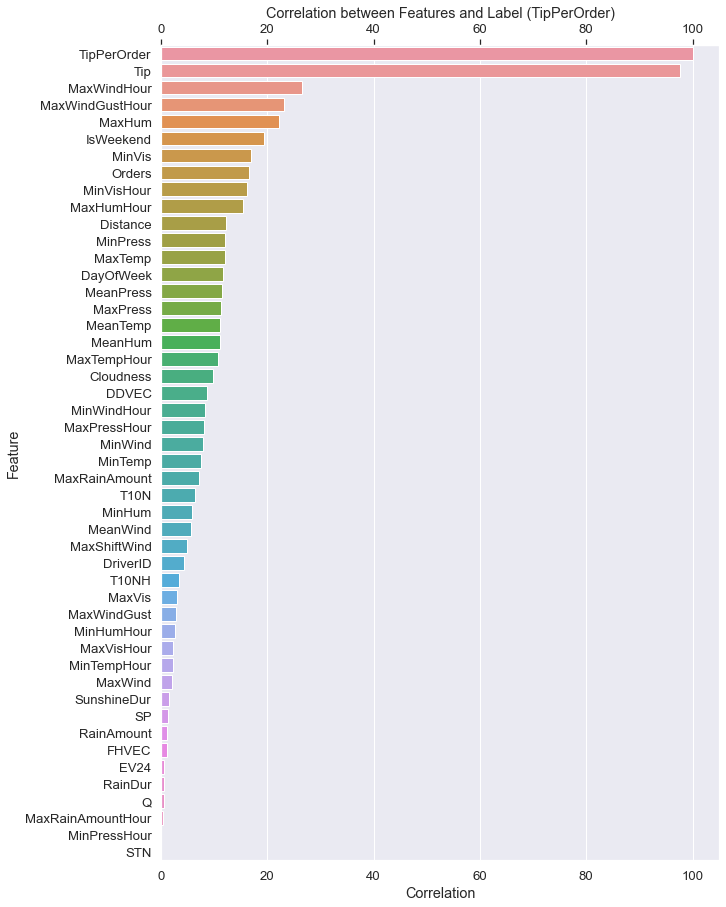

In [ ]:
cols = wdf.columns.values
T_NR = 4 # index of label column
cm = np.corrcoef(wdf[cols].dropna().values, rowvar=False)[T_NR]

plt.figure(figsize=(10,15))
sns.set(font_scale=1.2)

cor = pd.DataFrame({'col': cols, 'val':cm})
cor['abs_val'] = abs(cor['val']) * 100
cor = cor.sort_values('abs_val', ascending=False)
ax = sns.barplot(y='col', x='abs_val', data=cor)
ax_top = ax.secondary_xaxis('top')
ax.set(xlabel='Correlation', ylabel='Feature', title='Correlation between Features and Label (TipPerOrder)')

plt.show()

Rather unexpectedly we notice that the features that have most corellation with `TipPerOrder` are:
*   `MaxWindHour` – The hour in which the highest mean hourly windspeed has been registered that day (Remarkably, how fast the wind was, doesn't matter that much)
*   `MaxWindGustHour` – The hour when the fastest stream of air has been registered (Again, the speed itself mattering less)
*   `MaxHum` – The highest value of air hummidity
*   `IsWeekend` – Whether it is one of: Friday, Saturday, Sunday
*   `MinVis` – The lowest registered visibility

Equally remarkable are the features that seem to have no correlation with `TipPerOrder`:
* `RainDur`, `RainAmount` – Looks like people don't care at all weather it rains or not
* `SunshineDur`, `MaxWind`, `MinTemp` seem to be other things that don't affect people's tipping

Let's plot these features and see if we can spot any patterns.


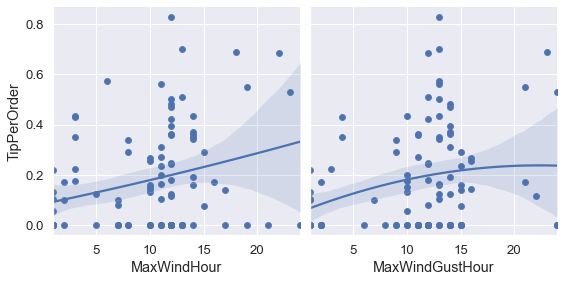

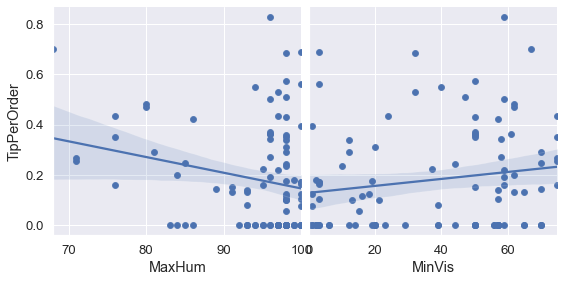

In [ ]:
g = sns.pairplot(wdf, x_vars=['MaxWindHour', 'MaxWindGustHour'], y_vars=['TipPerOrder'],height = 4)
g.map(sns.regplot, order=2)

g = sns.pairplot(wdf, x_vars=['MaxHum', 'MinVis'], y_vars=['TipPerOrder'],height = 4)
g.map(sns.regplot)

plt.show()

Looks like there may be some correlations in those observations.

I am still curious about the features for which we found no corelation at all when it feels like there should be some. It is possible that our correlation calculation is wrong. 

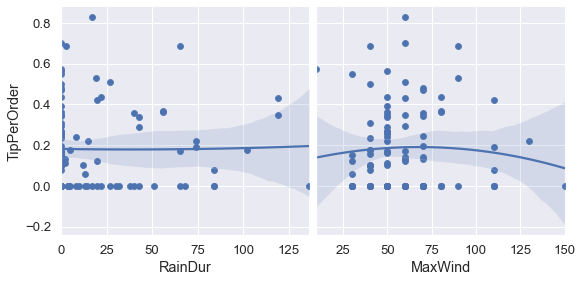

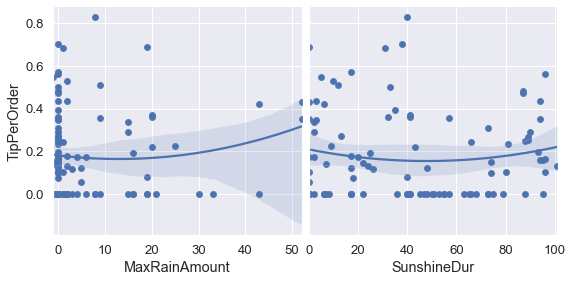

In [ ]:
g = sns.pairplot(wdf, x_vars=['RainDur', 'MaxWind'], y_vars=['TipPerOrder'],height = 4)
g.map(sns.regplot, order=2)

g = sns.pairplot(wdf, x_vars=['MaxRainAmount', 'SunshineDur'], y_vars=['TipPerOrder'],height = 4)
g.map(sns.regplot, order=2)

Actually our correlation calculation seems to be correct, these features are indeed in no way related to the label.

# Modeling

We are trying to predict a continious value from a relatievely small dataset with potentially many features. 

The goal of the model is **not** to predict the tip accurately every day but to provide assistance in choosing the days that will, on average, over longer periods of time be the most profitable. Predicting the `TipPerORder` is just an easy instrumental goal to that extent.

The following models will be considered:
* SVR Linear Kernel
* RidgeRegression
* SVR RBF Kernel
* Ensamble Regressors
* Lasso
* Elastic Net

## Evaluation

The model will be evaluated using corss-validation and with new data as it comes in.

# Conclusion

We have investigated multiple datasets and found statistically significant corelations. With the insights gathered so far and additional feature and model engineering it will be possible to generate useful predictions. 
